# Statistical Analysis STAR-RIS Assisted CoMP-NOMA

In [1]:
import numpy as np
import scipy as sp
import mpmath as mpm
from scipy.special import gamma
import sympy as sym
from sympy import meijerg
from sympy import N as NEval
import matplotlib.pyplot as plt
import simcomm.core.propagation as prop
from simcomm.core import Nakagami, get_rvs
from simcomm.utils import dbm2pow, db2pow, pow2db, pow2dbm, get_distance
from simcomm.core.propagation import get_noise_power, get_pathloss

In [2]:
environment = {
    "positions": {
        "BS1": [-50, 0, 25],  # BS1 position
        "BS2": [50, 0, 25],  # BS2 position
        "RIS": [0, 25, 5],  # RIS position
        "Uf": [0, 35, 1],  # Uf position
        "U1c": [-40, 18, 1],  # U1c position
        "U2c": [30, 22, 1],  # U2c position
    },
    "fading": {
        "rayleigh": {"type": "rayleigh", "sigma": 1},  # Rayleigh fading
        "ricianE": {
            "type": "rician",
            "K": 5,
            "sigma": 1,
        },  # Rician fading for edge users
        "ricianC": {
            "type": "rician",
            "K": 3,
            "sigma": 1,
        },  # Rician fading for center users
        "nakagami-1": {"type": "nakagami", "m": 1, "omega": 1},
        "nakagami-2": {"type": "nakagami", "m": 2, "omega": 1},
    },
    "pathloss": {
        "center": {"type": "free-space", "alpha": 3, "p0": 30},  # Center users
        "ris": {"type": "free-space", "alpha": 3, "p0": 30},  # BS to RIS
        "risC": {"type": "free-space", "alpha": 2.7, "p0": 30},  # RIS to center users
        "risE": {"type": "free-space", "alpha": 2.3, "p0": 30},  # RIS to edge user
        "edge": {"type": "free-space", "alpha": 3.5, "p0": 30},  # Edge users
        "inter": {"type": "free-space", "alpha": 3.5, "p0": 30},  # Interference links
    },
}

setting = {
    "ris32": {
        "ris_enhanced": True,  # RIS with 32 elements
        "ris_elements": 32,
        "comp_enabled": True,  # CoMP enabled
    },
    "no_ris": {
        "ris_enhanced": False,  # No RIS
        "comp_enabled": True,  # CoMP enabled"
    },
    "ris70": {
        "ris_enhanced": True,  # RIS with 70 elements
        "ris_elements": 70,
        "comp_enabled": True,  # CoMP enabled
    },
    "no_ris_non_comp": {
        "ris_enhanced": False,  # No RIS
        "comp_enabled": False,  # CoMP disabled
    },
}

constants = {
    "BANDWIDTH": 1e6,  # Bandwidth in Hz
    "TEMP": 300,  # Temperature in Kelvin
    "FREQ": 2.4e9,  # Frequency of carrier signal in Hz
    "SIGMA": 6.32,  # Shadowing standard deviation in dB
}

# Load the environment
pathloss_cfg = environment["pathloss"]
fading_cfg = environment["fading"]
positions = environment["positions"]

# Additional parameters
BANDWIDTH = constants["BANDWIDTH"]  # Bandwidth in Hz
TEMP = constants["TEMP"]  # Temperature in Kelvin
FREQ = constants["FREQ"]  # Frequency of carrier signal in Hz
SIGMA = constants["SIGMA"]  # Shadowing standard deviation in dB

In [3]:
# Positions
pos_BS1 = positions["BS1"]
pos_BS2 = positions["BS2"]
pos_RIS = positions["RIS"]
pos_U1c = positions["U1c"]
pos_U2c = positions["U2c"]
pos_Uf = positions["Uf"]

# Distance parameters
## BS1 specific distances
distance_iR = get_distance(pos_BS1, pos_RIS, 3)
distance_Rc = get_distance(pos_RIS, pos_U1c, 3)
distance_ic = get_distance(pos_BS1, pos_U1c, 3)
distance_if = get_distance(pos_BS1, pos_Uf, 3)

## BS2 specific distances
distance_iR_hat = get_distance(pos_BS2, pos_RIS, 3)
distance_if_hat = get_distance(pos_BS2, pos_Uf, 3)

## Common distances
distance_Rf = get_distance(pos_RIS, pos_U1c, 3)
distance_ic_prime = get_distance(pos_BS2, pos_U1c, 3)

# Simulation parameters
K = 20
N = 10000
beta_r = 0.5
beta_t = 0.5
shape = (N, 1)
shape_ris = (K // 2, N, 1)

# Additional parameters
BANDWIDTH = constants["BANDWIDTH"]  # Bandwidth in Hz
TEMP = constants["TEMP"]  # Temperature in Kelvin
FREQ = constants["FREQ"]  # Frequency of carrier signal in Hz
SIGMA = constants["SIGMA"]  # Shadowing standard deviation in dB

Pt = np.linspace(-30, 30, 61)  # Transmit power in dBm
Pt_lin = dbm2pow(Pt)  # Transmit power in linear scale
N0 = get_noise_power(BANDWIDTH, TEMP, 12)  # Noise power in dBm
N0_lin = dbm2pow(N0)  # Noise power in linear scale

# Power allocation
zeta_ic = 0.3
zeta_if = 0.7
zeta_ic_hat = 0.3
zeta_if_hat = 0.7

rho = Pt_lin / N0_lin  # SNR

## Simulation

In [4]:
pathloss_iR = get_pathloss(**pathloss_cfg["ris"], distance=distance_iR, frequency=FREQ)
pathloss_Rc = get_pathloss(**pathloss_cfg["risC"], distance=distance_Rc, frequency=FREQ)
pathloss_ic = get_pathloss(
    **pathloss_cfg["center"], distance=distance_ic, frequency=FREQ
)
pathloss_ic_prime = get_pathloss(
    **pathloss_cfg["inter"], distance=distance_ic_prime, frequency=FREQ
)
pathloss_if = get_pathloss(**pathloss_cfg["edge"], distance=distance_if, frequency=FREQ)
pathloss_iR_hat = get_pathloss(
    **pathloss_cfg["ris"], distance=distance_iR_hat, frequency=FREQ
)
pathloss_if_hat = get_pathloss(
    **pathloss_cfg["edge"], distance=distance_if_hat, frequency=FREQ
)
pathloss_Rf = get_pathloss(**pathloss_cfg["risE"], distance=distance_Rf, frequency=FREQ)

samples_iR = get_rvs(**{"type": "nakagami", "m": 2, "omega": 1}, shape=shape_ris)
samples_Rc = get_rvs(**{"type": "nakagami", "m": 2, "omega": 1}, shape=shape_ris)
samples_ic = get_rvs(**{"type": "nakagami", "m": 1, "omega": 1}, shape=shape)
samples_ic_prime = get_rvs(**{"type": "nakagami", "m": 1, "omega": 1}, shape=shape)

samples_if = get_rvs(**{"type": "nakagami", "m": 1, "omega": 1}, shape=shape)
samples_iR_hat = get_rvs(**{"type": "nakagami", "m": 2, "omega": 1}, shape=shape_ris)
samples_if_hat = get_rvs(**{"type": "nakagami", "m": 1, "omega": 1}, shape=shape)
samples_Rf = get_rvs(**{"type": "nakagami", "m": 2, "omega": 1}, shape=shape_ris)

In [5]:
h_iR = np.abs(np.sqrt(db2pow(-1 * pathloss_iR)) * samples_iR)
h_Rc = np.abs(np.sqrt(db2pow(-1 * pathloss_Rc)) * samples_Rc)
h_ic = np.abs(np.sqrt(db2pow(-1 * pathloss_ic)) * samples_ic)
h_ic_prime = np.abs(np.sqrt(db2pow(-1 * pathloss_ic_prime)) * samples_ic_prime)
h_if = np.abs(np.sqrt(db2pow(-1 * pathloss_if)) * samples_if)
h_iR_hat = np.abs(np.sqrt(db2pow(-1 * pathloss_iR_hat)) * samples_iR_hat)
h_if_hat = np.abs(np.sqrt(db2pow(-1 * pathloss_if_hat)) * samples_if_hat)
h_Rf = np.abs(np.sqrt(db2pow(-1 * pathloss_Rf)) * samples_Rf)

cascaded_ic = np.sum(h_iR * h_Rc, axis=0) * np.sqrt(beta_r)
H_ic = cascaded_ic + h_ic

cascaded_if = np.sum(h_iR * h_Rf, axis=0) * np.sqrt(beta_t)
cascaded_if_hat = np.sum(h_iR_hat * h_Rf, axis=0) * np.sqrt(beta_t)
H_if = cascaded_if + h_if
H_if_hat = cascaded_if_hat + h_if_hat

## SINR PDFs

### PDF of SINR $\gamma_{i,c\rightarrow f}$

Effective Channel $\textbf{H}_{i, c}=\textbf{h}_{i, c}+\textbf{h}_{R, c}^H \mathbf{\Theta_r}\textbf{h}_{i, R}$

Channel Gain $Z_{i,c} = |H_{i,c}|^2 = (h_{i,c} + G_{i,R,c})^2$

Direct Channel $h_{i,c}$

In [6]:
m_ic = 1
omega_ic = 1 * db2pow(-1 * pathloss_ic)
omega_ic_prime = 1 * db2pow(-1 * pathloss_ic_prime)

In [7]:
def fun_mu_h_ic(p, m_ic, omega_ic):
    return (gamma(m_ic + p / 2) / gamma(m_ic)) * (m_ic / omega_ic) ** (-p / 2)

In [8]:
mu_h_ic = fun_mu_h_ic(1, m_ic, omega_ic)  # 1st moment of h_ic
mu_h_ic_2 = fun_mu_h_ic(2, m_ic, omega_ic)  # 2nd moment of h_ic

k_h_ic = (mu_h_ic**2) / (mu_h_ic_2 - mu_h_ic**2)  # Shape parameter of h_ic
theta_h_ic = (mu_h_ic_2 - mu_h_ic**2) / mu_h_ic  # Scale parameter of h_ic

Cascaded Channel $G_{i,R,c} = \sqrt{\beta_r} \sum_{k=1}^{K} |{h_{R,c}}||{h_{i,R}}|$

In [9]:
m_iR = 2
m_Rc = 2
omega_iR = 1 * db2pow(-1 * pathloss_iR)
omega_Rc = 1 * db2pow(-1 * pathloss_Rc)

In [10]:
def fun_mu_h_iR(p, m_iR, omega_iR):
    return gamma(m_iR + p / 2) / gamma(m_iR) * (m_iR / omega_iR) ** (-p / 2)


def fun_mu_h_Rc(p, m_Rc, omega_Rc):
    return gamma(m_Rc + p / 2) / gamma(m_Rc) * (m_Rc / omega_Rc) ** (-p / 2)

In [11]:
def fun_mu_G_iRc(p, m_iR, omega_iR, m_Rc, omega_Rc, K, beta_r):
    mu = (gamma(m_iR + (1 / 2)) * gamma(m_Rc + (1 / 2))) / (
        gamma(m_iR) * gamma(m_Rc) * (m_iR * m_Rc) ** (1 / 2)
    )
    k = mu**2 / (1 - mu**2)
    theta = (1 - mu**2) / mu

    return (
        gamma((K * k) + p) * (np.sqrt(omega_iR * omega_Rc * beta_r) * theta) ** p
    ) / gamma(K * k)


mu_G_iRc = fun_mu_G_iRc(
    1, m_iR, omega_iR, m_Rc, omega_Rc, K // 2, beta_r
)  # 1st moment of G_iRc
mu_G_iRc_2 = fun_mu_G_iRc(
    2, m_iR, omega_iR, m_Rc, omega_Rc, K // 2, beta_r
)  # 2nd moment of G_iRc

k_G_iRc = mu_G_iRc**2 / (mu_G_iRc_2 - mu_G_iRc**2)  # Shape parameter of G_iRc
theta_G_iRc = (mu_G_iRc_2 - mu_G_iRc**2) / mu_G_iRc  # Scale parameter of G_iRc

Effective Channel Gain $Z_{i,c} = |H_{i,c}|^2 = (h_{i,c} + G_{i,R,c})^2$

In [12]:
mu_Z_ic = (
    fun_mu_G_iRc(2, m_iR, omega_iR, m_Rc, omega_Rc, K // 2, beta_r)
    + fun_mu_h_ic(2, m_ic, omega_ic)
    + (
        2
        * fun_mu_G_iRc(1, m_iR, omega_iR, m_Rc, omega_Rc, K // 2, beta_r)
        * fun_mu_h_ic(1, m_ic, omega_ic)
    )
)

mu_Z_ic_2 = (
    fun_mu_G_iRc(4, m_iR, omega_iR, m_Rc, omega_Rc, K // 2, beta_r)
    + fun_mu_h_ic(4, m_ic, omega_ic)
    + (
        6
        * fun_mu_G_iRc(2, m_iR, omega_iR, m_Rc, omega_Rc, K // 2, beta_r)
        * fun_mu_h_ic(2, m_ic, omega_ic)
    )
    + (
        4
        * fun_mu_h_ic(3, m_ic, omega_ic)
        * fun_mu_G_iRc(1, m_iR, omega_iR, m_Rc, omega_Rc, K // 2, beta_r)
    )
    + (
        4
        * fun_mu_h_ic(1, m_ic, omega_ic)
        * fun_mu_G_iRc(3, m_iR, omega_iR, m_Rc, omega_Rc, K // 2, beta_r)
    )
)

k_Z_ic = mu_Z_ic**2 / (mu_Z_ic_2 - mu_Z_ic**2)  # Shape parameter of Z_ic
theta_Z_ic = (mu_Z_ic_2 - mu_Z_ic**2) / mu_Z_ic  # Scale parameter of Z_ic

$\mathcal{V_{i,c,f}} = {\zeta_{i,f}\rho|\textbf{H}_{i,c}|^2},$

where $\rho = \frac{P}{\sigma^2}$

In [13]:
simulation_V_icf = zeta_if * rho * H_ic**2

In [14]:
k_V_icf = k_Z_ic * np.ones_like(rho)
theta_V_icf = theta_Z_ic * zeta_if * rho

$\mathcal{B_{i,c,f}} = {\zeta_{i,c}\rho|\textbf{H}_{i,c}|^2 + \rho|\textbf{h}_{i,c^\prime}|^2 +  1}$

$\mathcal{B_{i,c,f}} = {\mathcal{W_{i,c}} +  1}$,

where $\mathcal{W_{i,c,f}} = \zeta_{i,c}\rho|\textbf{H}_{i,c}|^2 + \rho|\textbf{h}_{i,c^\prime}|^2$

In [15]:
simulation_W_icf = (zeta_ic * rho * H_ic**2) + (rho * h_ic_prime**2)
simulation_B_icf = simulation_W_icf + 1

$\mu _{\mathcal{W}_{\text{ic}}} = \rho  \mu _{h_{\text{ic}}}+\zeta  \rho  \mu _{Z_{\text{ic}}}$

$\mu _{\mathcal{W}_{\text{ic}}}^{(2)} = \rho ^2 \left(\zeta  \left(2 \mu _{h_{\text{ic}}} \mu
   _{Z_{\text{ic}}}+\zeta  \mu _{Z_{\text{ic2}}}\right)+\mu
   _{h_{\text{ic2}}}\right)$

In [16]:
def fun_mu_h_ic_sqr_interf(p, m_ic, omega_ic):
    return (gamma(m_ic + p) / gamma(m_ic)) * (m_ic / omega_ic) ** (-p)

In [17]:
mu_W_icf = (
    rho * fun_mu_h_ic_sqr_interf(1, m_ic, omega_ic_prime) + zeta_ic * rho * mu_Z_ic
)  # 1st moment of W_ic

mu_W_icf_2 = rho**2 * (
    zeta_ic
    * (
        (2 * fun_mu_h_ic_sqr_interf(1, m_ic, omega_ic_prime) * mu_Z_ic)
        + zeta_ic * mu_Z_ic_2
    )
    + fun_mu_h_ic_sqr_interf(2, m_ic, omega_ic_prime)
)  # 2nd moment of W_ic

k_W_icf = mu_W_icf**2 / (mu_W_icf_2 - mu_W_icf**2)  # Shape parameter of W_ic
theta_W_icf = (mu_W_icf_2 - mu_W_icf**2) / mu_W_icf  # Scale parameter of W_ic

In [18]:
mu_B_icf = mu_W_icf + 1  # 1st moment of B_icf
mu_B_icf_2 = mu_W_icf_2 + 2 * mu_W_icf + 1  # 2nd moment of B_icf

k_B_icf = mu_B_icf**2 / (mu_B_icf_2 - mu_B_icf**2)  # Shape parameter of B_icf
theta_B_icf = (mu_B_icf_2 - mu_B_icf**2) / mu_B_icf  # Scale parameter of B_icf

In [19]:
simulation_SINR_icf = simulation_V_icf / simulation_B_icf

In [20]:
def generalized_beta_prime_pdf(x, a, b, p, q):
    return (p * ((x / q) ** (a * p - 1)) * (1 + (x / q) ** p) ** (-a - b)) / (
        q * sp.special.beta(a, b)
    )


def hypergeometric_f1_regularized(a, b, c):
    return sp.special.hyp1f1(a, b, c) / sp.special.gamma(b)

### PDF of SINR $\gamma_{i,c}$

$\mathcal{V_{i,c}} = {\zeta_{i,c}\rho|\textbf{H}_{i,c}|^2},$

where $\rho = \frac{P}{\sigma^2}$

In [21]:
simulation_V_ic = zeta_ic * rho * H_ic**2

In [22]:
k_V_ic = k_Z_ic * np.ones_like(rho)
theta_V_ic = theta_Z_ic * zeta_ic * rho

$\mathcal{B_{i,c}} = {\rho|\textbf{h}_{i,c^\prime}|^2 +  1}$

$\mathcal{B_{i,c}} = {\mathcal{W_{i,c}} +  1}$,

where $\mathcal{W_{i,c}} = \rho|\textbf{h}_{i,c^\prime}|^2$

In [23]:
simulation_B_ic = (rho * h_ic_prime**2) + 1

In [24]:
def fun_mu_h_ic_sqr_interf(p, m_ic, omega_ic):
    return (gamma(m_ic + p) / gamma(m_ic)) * (m_ic / omega_ic) ** (-p)

In [25]:
mu_W_ic = rho * fun_mu_h_ic_sqr_interf(1, m_ic, omega_ic_prime)  # 1st moment of W_ic
mu_W_ic_2 = rho**2 * fun_mu_h_ic_sqr_interf(
    2, m_ic, omega_ic_prime
)  # 2nd moment of W_ic

k_W_ic = mu_W_ic**2 / (mu_W_ic_2 - mu_W_ic**2)  # Shape parameter of W_ic
theta_W_ic = (mu_W_ic_2 - mu_W_ic**2) / mu_W_ic  # Scale parameter of W_ic

In [26]:
mu_B_ic = mu_W_ic + 1  # 1st moment of B_ic
mu_B_ic_2 = mu_W_ic_2 + 2 * mu_W_ic + 1  # 2nd moment of B_ic

k_B_ic = mu_B_ic**2 / (mu_B_ic_2 - mu_B_ic**2)  # Shape parameter of B_ic
theta_B_ic = (mu_B_ic_2 - mu_B_ic**2) / mu_B_ic  # Scale parameter of B_ic

In [27]:
simulation_SINR_ic = simulation_V_ic / simulation_B_ic

### PDF of SINR $\gamma_{f}$

Effective Channel $\textbf{H}_{i, f}=\textbf{h}_{i, f}+\textbf{h}_{R, f}^H \mathbf{\Theta_r}\textbf{h}_{i, R}$

Channel Gain $Z_{i,f} = |H_{i,f}|^2 = (h_{i,f} + G_{i,R,f})^2$

Direct Channel $h_{i,f}$

Additionally, $\hat{i} \in \mathcal{I}_c \backslash i$

In [28]:
m_if = 1
m_if_hat = 1
omega_if = 1 * db2pow(-1 * pathloss_if)
omega_if_hat = 1 * db2pow(-1 * pathloss_if_hat)

In [29]:
def fun_mu_h_if(p, m_if, omega_if):
    return (gamma(m_if + p / 2) / gamma(m_if)) * (m_if / omega_if) ** (-p / 2)

In [30]:
mu_h_if = fun_mu_h_if(1, m_if, omega_if)  # 1st moment of h_if
mu_h_if_2 = fun_mu_h_if(2, m_if, omega_if)  # 2nd moment of h_if
mu_h_if_hat = fun_mu_h_if(1, m_if_hat, omega_if_hat)  # 1st moment of h_if_hat
mu_h_if_hat_2 = fun_mu_h_if(2, m_if_hat, omega_if_hat)  # 2nd moment of h_if_hat

k_h_if = (mu_h_if**2) / (mu_h_if_2 - mu_h_if**2)  # Shape parameter of h_if
theta_h_if = (mu_h_if_2 - mu_h_if**2) / mu_h_if  # Scale parameter of h_if

k_h_if_hat = (mu_h_if_hat**2) / (
    mu_h_if_hat_2 - mu_h_if_hat**2
)  # Shape parameter of h_if_hat
theta_h_if_hat = (
    mu_h_if_hat_2 - mu_h_if_hat**2
) / mu_h_if_hat  # Scale parameter of h_if_hat

Cascaded Channel $G_{i,R,f} = \sqrt{\beta_t} \sum_{k=1}^{K} |{h_{R,f}}||{h_{i,R}}|$

In [31]:
m_iR = 2
m_iR_hat = 2
m_Rf = 2
omega_iR = 1 * db2pow(-1 * pathloss_iR)
omega_iR_hat = 1 * db2pow(-1 * pathloss_iR_hat)
omega_Rf = 1 * db2pow(-1 * pathloss_Rf)

In [32]:
def fun_mu_h_iR(p, m_iR, omega_iR):
    return gamma(m_iR + p / 2) / gamma(m_iR) * (m_iR / omega_iR) ** (-p / 2)


def fun_mu_h_Rf(p, m_Rf, omega_Rf):
    return gamma(m_Rf + p / 2) / gamma(m_Rf) * (m_Rf / omega_Rf) ** (-p / 2)

In [33]:
def fun_mu_G_iRf(p, m_iR_hat, omega_iR_hat, m_Rf, omega_Rf, K, beta_t):
    mu = (gamma(m_iR_hat + (1 / 2)) * gamma(m_Rf + (1 / 2))) / (
        gamma(m_iR_hat) * gamma(m_Rf) * (m_iR_hat * m_Rf) ** (1 / 2)
    )
    k = mu**2 / (1 - mu**2)
    theta = (1 - mu**2) / mu

    return (
        gamma((K * k) + p) * (np.sqrt(omega_iR_hat * omega_Rf * beta_t) * theta) ** p
    ) / gamma(K * k)


mu_G_iRf = fun_mu_G_iRf(
    1, m_iR, omega_iR, m_Rf, omega_Rf, K // 2, beta_t
)  # 1st moment of G_iRc
mu_G_iRf_2 = fun_mu_G_iRf(
    2, m_iR, omega_iR, m_Rf, omega_Rf, K // 2, beta_t
)  # 2nd moment of G_iRc

mu_G_iRf_hat = fun_mu_G_iRf(
    1, m_iR_hat, omega_iR_hat, m_Rf, omega_Rf, K // 2, beta_t
)  # 1st moment of G_iRc
mu_G_iRf_hat_2 = fun_mu_G_iRf(
    2, m_iR_hat, omega_iR_hat, m_Rf, omega_Rf, K // 2, beta_t
)  # 2nd moment of G_iRcarameter of G_iRc

k_G_iRf = mu_G_iRf**2 / (mu_G_iRf_2 - mu_G_iRf**2)  # Shape parameter of G_iRc
theta_G_iRf = (mu_G_iRf_2 - mu_G_iRf**2) / mu_G_iRf  # Scale parameter of G_iRc

k_G_iRf_hat = mu_G_iRf_hat**2 / (
    mu_G_iRf_hat_2 - mu_G_iRf_hat**2
)  # Shape parameter of G_iRc
theta_G_iRf_hat = (
    mu_G_iRf_hat_2 - mu_G_iRf_hat**2
) / mu_G_iRf_hat  # Scale parameter of G_iRc

Effective Channel Gain $Z_{i,f} = |H_{i,f}|^2 = (h_{i,f} + G_{i,R,f})^2$

In [34]:
mu_Z_if = (
    fun_mu_G_iRf(2, m_iR, omega_iR, m_Rf, omega_Rf, K // 2, beta_t)
    + fun_mu_h_if(2, m_if, omega_if)
    + (
        2
        * fun_mu_G_iRf(1, m_iR, omega_iR, m_Rf, omega_Rf, K // 2, beta_t)
        * fun_mu_h_if(1, m_if, omega_if)
    )
)

mu_Z_if_2 = (
    fun_mu_G_iRf(4, m_iR, omega_iR, m_Rf, omega_Rf, K // 2, beta_t)
    + fun_mu_h_if(4, m_if, omega_if)
    + (
        6
        * fun_mu_G_iRf(2, m_iR, omega_iR, m_Rf, omega_Rf, K // 2, beta_t)
        * fun_mu_h_if(2, m_if, omega_if)
    )
    + (
        4
        * fun_mu_h_if(3, m_if, omega_if)
        * fun_mu_G_iRf(1, m_iR, omega_iR, m_Rf, omega_Rf, K // 2, beta_t)
    )
    + (
        4
        * fun_mu_h_if(1, m_if, omega_if)
        * fun_mu_G_iRf(3, m_iR, omega_iR, m_Rf, omega_Rf, K // 2, beta_t)
    )
)

mu_Z_if_hat = (
    fun_mu_G_iRf(2, m_iR_hat, omega_iR_hat, m_Rf, omega_Rf, K // 2, beta_t)
    + fun_mu_h_if(2, m_if_hat, omega_if_hat)
    + (
        2
        * fun_mu_G_iRf(1, m_iR_hat, omega_iR_hat, m_Rf, omega_Rf, K // 2, beta_t)
        * fun_mu_h_if(1, m_if_hat, omega_if_hat)
    )
)

mu_Z_if_hat_2 = (
    fun_mu_G_iRf(4, m_iR_hat, omega_iR_hat, m_Rf, omega_Rf, K // 2, beta_t)
    + fun_mu_h_if(4, m_if_hat, omega_if_hat)
    + (
        6
        * fun_mu_G_iRf(2, m_iR_hat, omega_iR_hat, m_Rf, omega_Rf, K // 2, beta_t)
        * fun_mu_h_if(2, m_if_hat, omega_if_hat)
    )
    + (
        4
        * fun_mu_h_if(3, m_if_hat, omega_if_hat)
        * fun_mu_G_iRf(1, m_iR_hat, omega_iR_hat, m_Rf, omega_Rf, K // 2, beta_t)
    )
    + (
        4
        * fun_mu_h_if(1, m_if_hat, omega_if_hat)
        * fun_mu_G_iRf(3, m_iR_hat, omega_iR_hat, m_Rf, omega_Rf, K // 2, beta_t)
    )
)

k_Z_if = mu_Z_if**2 / (mu_Z_if_2 - mu_Z_if**2)  # Shape parameter of Z_if
theta_Z_if = (mu_Z_if_2 - mu_Z_if**2) / mu_Z_if  # Scale parameter of Z_if

k_Z_if_hat = mu_Z_if_hat**2 / (
    mu_Z_if_hat_2 - mu_Z_if_hat**2
)  # Shape parameter of Z_if_hat
theta_Z_if_hat = (
    mu_Z_if_hat_2 - mu_Z_if_hat**2
) / mu_Z_if_hat  # Scale parameter of Z_if_hat

$\mathcal{V}_{f}=\zeta_{i,f}\rho|\textbf{H}_{i, f}|^2 + \zeta_{i',f}\rho|\textbf{H}_{i', f}|^2$

In [35]:
simulation_V_f = zeta_if * rho * H_if**2 + zeta_if_hat * rho * H_if_hat**2

In [36]:
mu_V_f = (zeta_if * rho * mu_Z_if) + (
    zeta_if_hat * rho * mu_Z_if_hat
)  # 1st moment of V_f

mu_V_f_2 = rho**2 * (
    (zeta_if * k_Z_if * theta_Z_if) ** 2
    + (zeta_if_hat**2 * k_Z_if_hat * (1 + k_Z_if_hat) * theta_Z_if_hat**2)
    + (
        zeta_if
        * k_Z_if
        * theta_Z_if
        * (zeta_if * theta_Z_if + 2 * zeta_if_hat * k_Z_if_hat * theta_Z_if_hat)
    )
)  # 2nd moment of V_f

k_V_f = mu_V_f**2 / (mu_V_f_2 - mu_V_f**2)  # Shape parameter of V_f
theta_V_f = (mu_V_f_2 - mu_V_f**2) / mu_V_f  # Scale parameter of V_f

$\mathcal{B}_{f}=\zeta_{i,c}\rho|\textbf{H}_{i, f}|^2 + \zeta_{i',c}\rho|\textbf{H}_{i', f}|^2 + 1$

$\mathcal{B}_{f}=\mathcal{W}_{f} + 1$

$\mathcal{W}_{f}=\zeta_{i,c}\rho|\textbf{H}_{i, f}|^2 + \zeta_{i',c}\rho|\textbf{H}_{i', f}|^2$

In [37]:
simulation_W_f = zeta_ic * rho * H_if**2 + zeta_ic_hat * rho * H_if_hat**2
simulation_B_f = simulation_W_f + 1

In [38]:
mu_W_f = (zeta_ic * rho * mu_Z_if) + (
    zeta_ic_hat * rho * mu_Z_if_hat
)  # 1st moment of W_f

mu_W_f_2 = rho**2 * (
    (zeta_ic * k_Z_if * theta_Z_if) ** 2
    + (zeta_ic_hat**2 * k_Z_if_hat * (1 + k_Z_if_hat) * theta_Z_if_hat**2)
    + (
        zeta_ic
        * k_Z_if
        * theta_Z_if
        * (zeta_ic * theta_Z_if + 2 * zeta_ic_hat * k_Z_if_hat * theta_Z_if_hat)
    )
)  # 2nd moment of W_f

k_W_f = mu_W_f**2 / (mu_W_f_2 - mu_W_f**2)  # Shape parameter of W_f
theta_W_f = (mu_W_f_2 - mu_W_f**2) / mu_W_f  # Scale parameter of W_f

In [39]:
mu_B_f = mu_W_f + 1  # 1st moment of B_f
mu_B_f_2 = mu_W_f_2 + 2 * mu_W_f + 1  # 2nd moment of B_f

k_B_f = mu_B_f**2 / (mu_B_f_2 - mu_B_f**2)  # Shape parameter of B_f
theta_B_f = (mu_B_f_2 - mu_B_f**2) / mu_B_f  # Scale parameter of B_f

In [40]:
simulation_SINR_f = simulation_V_f / simulation_B_f

## Ergodic Rates

$\mathcal{R(k,m,\theta,\Omega)}=\frac{1}{\Omega  \log (2) \Gamma (k) \Gamma (m)}{\pi  \csc (\pi  m) \left(\Omega  \Gamma (k+m) B_{\frac{\theta}{\Omega }}(m,-k-m+1)-\theta  k \Gamma (k) _3\tilde{F}_2\left(1,1,k+1;2,2-m;\frac{\theta }{\Omega}\right)\right)}$

In [41]:
def rate_matica(k, m, theta, omega):
    z = theta / omega

    return np.real(
        (
            (np.pi * 1 / (np.sin(np.pi * m)))
            * (
                (
                    omega
                    * mpm.gamma(k + m)
                    * (-mpm.betainc(m, (-1 * k) - (1 * m) + 1, theta / omega, 0))
                    - (
                        theta
                        * k
                        * mpm.gamma(k)
                        * (
                            mpm.hyper([1, 1, 1 + k], [2, 2 - mpm.mpf(m)], z, maxprec=10000)
                            / (mpm.gamma(2) * mpm.gamma(2 - mpm.mpf(m)))
                        )
                    )
                )
            )
        )
        / (omega * np.log(2) * mpm.gamma(mpm.mpf(k)) * mpm.gamma(mpm.mpf(m)))
    )

$\mathcal{R(k,m,\theta,\Omega)}=\frac{1}{{\log (2) \Gamma (k+m) B(k,m)}}{G_{3,3}^{3,2}\left(\frac{\Omega }{\theta }|
\begin{array}{c}
 0,1-m,1 \\
 0,0,k \\
\end{array}
\right)}$

In [42]:
def rate_meijerg(k, m, theta, omega):
    return (1 / (mpm.log(2) * mpm.beta(k, m) * mpm.gamma(k + m))) * mpm.meijerg(
        [[0, 1 - m], [1]], [[0, 0, k], []], mpm.mpf(omega) / mpm.mpf(theta)
    )

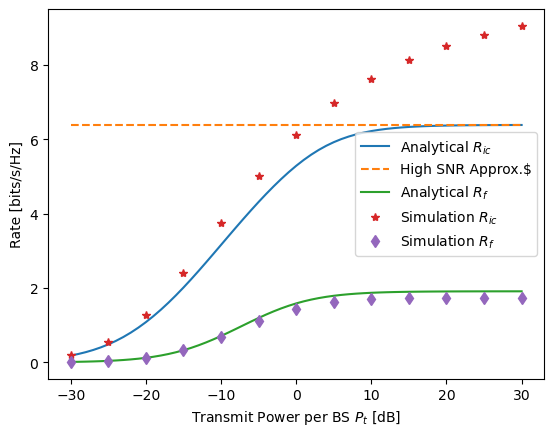

In [43]:
mpm.mp.dps = 25

rate_ic = np.zeros_like(rho)
rate_icH = np.zeros_like(rho)
rate_f = np.zeros_like(rho)

for i in range(len(rho)):
    rate_ic[i] = rate_meijerg(k_V_ic[i], k_B_ic[i], theta_V_ic[i], theta_B_ic[i])
    rate_icH[i] = rate_meijerg(k_V_ic[i], k_W_ic[i], theta_V_ic[i], theta_W_ic[i])
    rate_f[i] = rate_meijerg(k_V_f[i], k_B_f[i], theta_V_f[i], theta_B_f[i])

plt.plot(Pt, rate_ic, label="Analytical $R_{ic}$")
plt.plot(Pt, rate_icH, label="High SNR Approx.$", linestyle="--")
plt.plot(Pt, rate_f, label="Analytical $R_f$")
plt.plot(
    Pt,
    np.log2(1 + np.mean(simulation_SINR_ic, axis=0)),
    linestyle="",
    marker="*",
    markevery=5,
    label="Simulation $R_{ic}$",
)
plt.plot(
    Pt,
    np.log2(1 + np.mean(simulation_SINR_f, axis=0)),
    linestyle="",
    marker="d",
    markevery=5,
    label="Simulation $R_f$",
)
plt.xlabel("Transmit Power per BS $P_t$ [dB]")
plt.ylabel("Rate [bits/s/Hz]")
plt.legend()
plt.show()